In [1]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

import cv2
import time

# Device

In [2]:
print(f"Torch: {torch.__version__}")

Torch: 1.7.1


In [3]:
torch.cuda.is_available()

True

In [4]:
device = 'cuda'

# Load Data

In [5]:
data_dir = './dataset'

In [6]:
labels = os.listdir(data_dir)
print(labels)
print(len(labels))

['buttercup', 'coreopsis', 'daffodil', 'dandelion', 'sunflower']
5


In [7]:
data_list = []
data_labels_list = []
for i in labels:
    data_path = os.path.join(data_dir,i)
    temp1 = glob.glob(os.path.join(data_path,'*.jpg'))
    data_list += temp1
    temp2 = [i for j in range(len(temp1))]
    data_labels_list += temp2

In [8]:
print(f"Data: {len(data_list)}")
print(f"Labels: {len(data_labels_list)}")

Data: 4237
Labels: 4237


# Plot

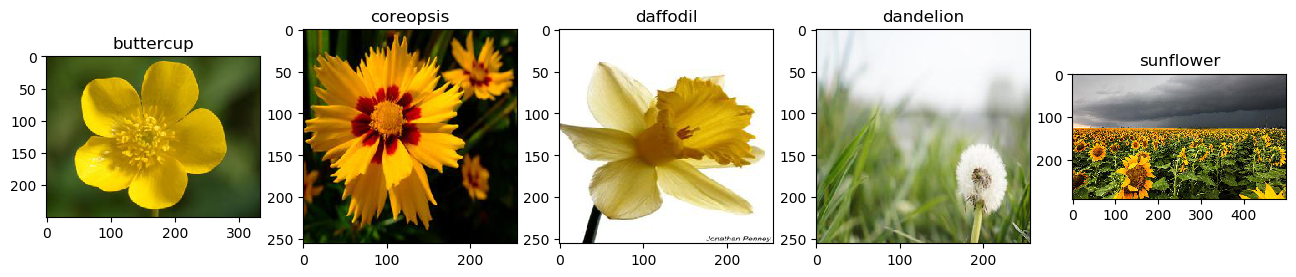

In [9]:
img_idx = [0,512,1474,2484,3505]
fig, axes = plt.subplots(1, 5, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(data_list[img_idx[idx]])
    ax.set_title(data_labels_list[img_idx[idx]])
    ax.imshow(img)

In [10]:
cv2.imread(data_list[0]).shape

(250, 333, 3)

# Split

In [11]:
seed = 42
batch_size = 32

In [12]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [13]:
train_list, valid_list = train_test_split(data_list, 
                                          test_size=0.2,
                                          stratify=data_labels_list,
                                          random_state=42)

In [14]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")

Train Data: 3389
Validation Data: 848


# Image Augmentation

In [15]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

# Load Datasets

In [16]:
class FlowerDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')
        img_transformed = self.transform(img)

        label = img_path.split("\\")[1]
        if label == "buttercup":
            label = 0
        elif label =="coreopsis":
            label = 1
        elif label == "daffodil":
            label = 2
        elif label == "dandelion":
            label = 3
        elif label == "sunflower":
            label = 4

        return img_transformed, label


In [17]:
train_data = FlowerDataset(train_list, transform=train_transforms)
valid_data = FlowerDataset(valid_list, transform=val_transforms)

In [18]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)

In [19]:
print(len(train_data), len(train_loader))

3389 106


In [20]:
print(len(valid_data), len(valid_loader))

848 27


In [21]:
train_data[0][0].shape

torch.Size([3, 224, 224])

# Model 1

In [22]:
# 224 * 224 * 3
class Vgg16_net(nn.Module):
    def __init__(self):
        super(Vgg16_net, self).__init__()
 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),  # 224 * 224 * 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
 
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1), # 224 * 224 * 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
 
            nn.MaxPool2d(kernel_size=2, stride=2)  # 112 * 112 * 64
        )
 
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # 112 * 112 * 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1), # 112 * 112 * 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
 
            nn.MaxPool2d(2, 2)  # 56 * 56 * 128
        )
 
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),  # 56 * 56 * 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
 
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),  # 56 * 56 * 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
 
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),  # 56 * 56 * 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
 
            nn.MaxPool2d(2, 2)  # 28 * 28 * 256
        )
 
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1), # 28 * 28 * 512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # 28 * 28 * 512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # 28 * 28 * 512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
 
            nn.MaxPool2d(2, 2)  # 14 * 14 * 512
        )
 
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # 14 * 14 * 512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # 14 * 14 * 512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
 
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1), # 14 * 14 * 512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
 
            nn.MaxPool2d(2, 2)  # 7 * 7 * 512
        )
 
        self.conv = nn.Sequential(
            self.layer1,
            self.layer2,
            self.layer3,
            self.layer4,
            self.layer5
        )
 
        self.fc = nn.Sequential(
            nn.Linear(7*7*512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
 
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
 
            nn.Linear(256, 5)
        )
 
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 7*7*512)
        x = self.fc(x)
        return x

In [23]:
def get_confusion_matrix(targets, outputs):
    labels = [0, 1, 2, 3]
    conf_matrix = confusion_matrix(y_true=targets, y_pred=outputs, labels=labels)
    return conf_matrix

In [24]:
def plot_confusion_matrix(conf_matrix,i):
    plt.imshow(X=conf_matrix, cmap=plt.cm.Greens)
    indices = range(conf_matrix.shape[0])
    labels = [0, 1, 2, 3]
    plt.xticks(ticks=indices, labels=labels)
    plt.yticks(ticks=indices, labels=labels)
    plt.colorbar()
    plt.xlabel('outputs')
    plt.ylabel('targets')
    plt.title('Confusion matrix of training'.format(i))
    for first_index in range(conf_matrix.shape[0]):
        for second_index in range(conf_matrix.shape[1]):
            plt.text(x=first_index, y=second_index, s=conf_matrix[first_index, second_index])
    #plt.savefig('heatmap_confusion_matrix.jpg')
    plt.show()

In [25]:
def plot_accuracies(train_acc):
    accuracies = [acc.item() for acc in train_acc]
    plt.plot(accuracies, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(train_loss):
    train_losses = [loss.item() for loss in train_loss]
    plt.plot(train_losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')
    plt.show()

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def train(model_):
    train_loss = []
    train_acc = []
    outputs_train = []
    targets_train = []
    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer
    optimizer = optim.Adam(model_.parameters(), lr=lr)
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in tqdm(train_loader):
            data = data.to(device)
            
            label = label.to(device)
            
            output = model_(data)

            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

            outputs_train.extend(item.cpu().detach().numpy() for item in output.argmax(1))
            targets_train.extend(item.cpu().detach().numpy() for item in label)

        train_loss.append(epoch_loss)
        train_acc.append(epoch_accuracy)
        print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}\n")

        
    print("Epoch:{}".format(epoch))
    print("Loss value in the last epoch of training is:{}".format(epoch_loss))
    print("Accuracy in the last epoch of training is:{}".format(epoch_accuracy))

    sklearn_report1 = classification_report(targets_train, outputs_train)
    print("Classification report of training:")
    print(sklearn_report1)

    conf_matrix1 = get_confusion_matrix(targets_train, outputs_train)
    print("Confusion matrix of training:")
    print(conf_matrix1)
    plot_confusion_matrix(conf_matrix1,epoch)
    
    plot_accuracies(train_acc)
    plot_losses(train_loss)

In [27]:
epochs = 30
lr = 5e-6
gamma = 0.7

In [28]:
model1 = Vgg16_net().to(device)

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.4708 - acc: 0.3707



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.2493 - acc: 0.5210



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.0523 - acc: 0.6132



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.9090 - acc: 0.6763



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.8012 - acc: 0.7148



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6908 - acc: 0.7700



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6058 - acc: 0.7993



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.5380 - acc: 0.8159



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.5006 - acc: 0.8252



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.4763 - acc: 0.8415



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.4453 - acc: 0.8480



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.4287 - acc: 0.8569



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.3867 - acc: 0.8732



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.3647 - acc: 0.8778



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.3385 - acc: 0.8897



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.3221 - acc: 0.8976



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.3119 - acc: 0.8929



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.2805 - acc: 0.9083



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.2723 - acc: 0.9153



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.2606 - acc: 0.9176



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.2401 - acc: 0.9221



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.2212 - acc: 0.9273



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.2416 - acc: 0.9221



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.2015 - acc: 0.9301



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.1872 - acc: 0.9389



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.1899 - acc: 0.9372



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.1816 - acc: 0.9442



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.1842 - acc: 0.9425



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.1645 - acc: 0.9469



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.1746 - acc: 0.9430

Epoch:29
Loss value in the last epoch of training is:0.1746283322572708
Accuracy in the last epoch of training is:0.9430403709411621
Classification report of training:
              precision    recall  f1-score   support

           0       0.82      0.67      0.74     11760
           1       0.80      0.84      0.82     23010
           2       0.84      0.89      0.87     24240
           3       0.90      0.90      0.90     24510
           4       0.81      0.80      0.80     18150

    accuracy                           0.84    101670
   macro avg       0.84      0.82      0.83    101670
weighted avg       0.84      0.84      0.84    101670

Confusion matrix of training:
[[ 7913  1246  1215   720]
 [  692 19272  1060   380]
 [  450   746 21693   813]
 [  299   670  1041 22005]]


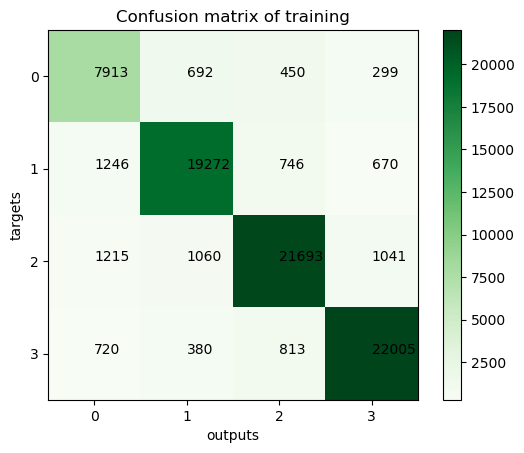

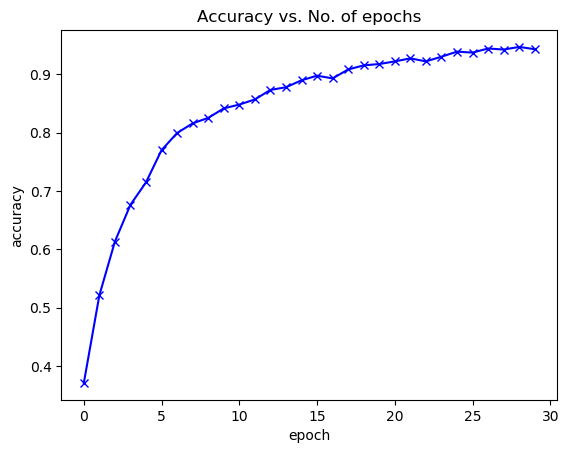

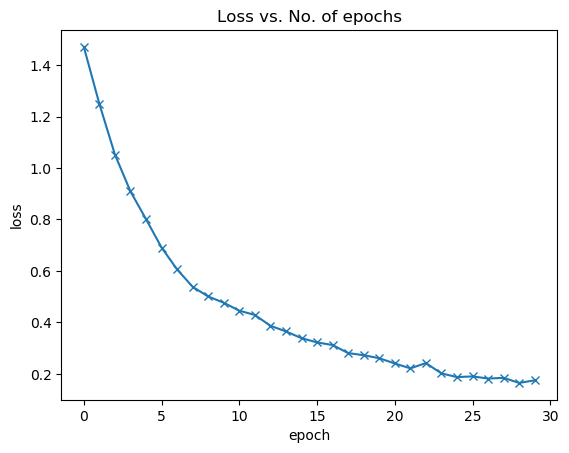

In [29]:
train(model1)

In [50]:
torch.save(model2.state_dict(), 'model3_params.pth')

In [28]:
model2 = Vgg16_net().to(device)
model2.load_state_dict(torch.load('model3_params.pth'))

<All keys matched successfully>

In [31]:
inference_time = 0
for i in range(32):
    data, label = train_loader.dataset[i]
    data = data.unsqueeze(0)
    data = data.to(device)

    torch.cuda.synchronize()
    start = time.time()

    output = model2(data)

    torch.cuda.synchronize()
    end = time.time()

    inference_time += (end - start)
print("Время инференса модели при обработке одного изображения：", inference_time/32, "с")

Время инференса модели при обработке одного изображения： 0.012890689074993134 с


In [41]:
data, label = train_loader.dataset[2]
data = data.unsqueeze(0)
data = data.to(device)

start = time.time()

output = model2(data)

end = time.time()

inference_time = (end - start)
print("Время инференса модели при обработке одного изображения：", inference_time, "с")

Время инференса модели при обработке одного изображения： 0.010637283325195312 с


In [33]:
outputs_val = []
targets_val = []
with torch.no_grad():
    for data, label in valid_loader:
        data = data.to(device)
        label = label.to(device)
        val_output = model2(data)
        outputs_val.extend(item.cpu().detach().numpy() for item in val_output.argmax(1))
        targets_val.extend(item.cpu().detach().numpy() for item in label)

sklearn_report2 = classification_report(targets_val, outputs_val)
print("Classification report of validation:")
print(sklearn_report2)

Classification report of validation:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81        98
           1       0.82      0.89      0.85       192
           2       0.91      0.91      0.91       202
           3       0.91      0.97      0.94       204
           4       0.91      0.84      0.88       152

    accuracy                           0.89       848
   macro avg       0.89      0.87      0.88       848
weighted avg       0.89      0.89      0.89       848



# Model2

In [34]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ConvNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 28 * 28, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [29]:
epochs = 100
lr = 1e-5
gamma = 0.7

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.4319 - acc: 0.4351



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.1577 - acc: 0.5677



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.0497 - acc: 0.5911



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.9859 - acc: 0.6177



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.9375 - acc: 0.6476



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.9105 - acc: 0.6684



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.8579 - acc: 0.6816



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.8302 - acc: 0.6956



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.8065 - acc: 0.7013



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.7864 - acc: 0.7073



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.7728 - acc: 0.7152



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.7552 - acc: 0.7215



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.7364 - acc: 0.7337



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.7232 - acc: 0.7359



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.7251 - acc: 0.7316



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.7068 - acc: 0.7418



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6843 - acc: 0.7485



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6704 - acc: 0.7546



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6642 - acc: 0.7565



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.6432 - acc: 0.7673



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 21 - loss : 0.6389 - acc: 0.7646



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 22 - loss : 0.6247 - acc: 0.7694



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 23 - loss : 0.6092 - acc: 0.7807



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 24 - loss : 0.5997 - acc: 0.7840



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 25 - loss : 0.5988 - acc: 0.7782



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 26 - loss : 0.5893 - acc: 0.7866



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 27 - loss : 0.5728 - acc: 0.7901



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 28 - loss : 0.5637 - acc: 0.7885



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 29 - loss : 0.5553 - acc: 0.7991



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 30 - loss : 0.5478 - acc: 0.8035



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 31 - loss : 0.5342 - acc: 0.8061



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 32 - loss : 0.5231 - acc: 0.8155



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 33 - loss : 0.5092 - acc: 0.8176



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 34 - loss : 0.5067 - acc: 0.8195



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 35 - loss : 0.5044 - acc: 0.8182



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 36 - loss : 0.4930 - acc: 0.8208



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 37 - loss : 0.4819 - acc: 0.8235



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 38 - loss : 0.4704 - acc: 0.8277



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 39 - loss : 0.4600 - acc: 0.8363



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 40 - loss : 0.4601 - acc: 0.8353



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 41 - loss : 0.4610 - acc: 0.8345



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 42 - loss : 0.4435 - acc: 0.8425



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 43 - loss : 0.4342 - acc: 0.8528



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 44 - loss : 0.4276 - acc: 0.8537



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 45 - loss : 0.4221 - acc: 0.8543



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 46 - loss : 0.4092 - acc: 0.8580



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 47 - loss : 0.4025 - acc: 0.8590



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 48 - loss : 0.4016 - acc: 0.8620



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 49 - loss : 0.3870 - acc: 0.8651



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 50 - loss : 0.3709 - acc: 0.8738



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 51 - loss : 0.3725 - acc: 0.8711



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 52 - loss : 0.3620 - acc: 0.8749



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 53 - loss : 0.3599 - acc: 0.8723



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 54 - loss : 0.3572 - acc: 0.8734



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 55 - loss : 0.3488 - acc: 0.8796



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 56 - loss : 0.3519 - acc: 0.8794



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 57 - loss : 0.3346 - acc: 0.8888



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 58 - loss : 0.3203 - acc: 0.8881



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 59 - loss : 0.3200 - acc: 0.8894



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 60 - loss : 0.3198 - acc: 0.8881



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 61 - loss : 0.3120 - acc: 0.8965



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 62 - loss : 0.3036 - acc: 0.8955



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 63 - loss : 0.3003 - acc: 0.9031



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 64 - loss : 0.2932 - acc: 0.9050



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 65 - loss : 0.2902 - acc: 0.9009



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 66 - loss : 0.2827 - acc: 0.9032



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 67 - loss : 0.2769 - acc: 0.9047



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 68 - loss : 0.2663 - acc: 0.9101



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 69 - loss : 0.2570 - acc: 0.9168



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 70 - loss : 0.2569 - acc: 0.9141



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 71 - loss : 0.2616 - acc: 0.9085



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 72 - loss : 0.2491 - acc: 0.9203



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 73 - loss : 0.2467 - acc: 0.9171



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 74 - loss : 0.2366 - acc: 0.9215



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 75 - loss : 0.2454 - acc: 0.9201



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 76 - loss : 0.2304 - acc: 0.9254



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 77 - loss : 0.2224 - acc: 0.9294



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 78 - loss : 0.2166 - acc: 0.9342



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 79 - loss : 0.2087 - acc: 0.9366



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 80 - loss : 0.2130 - acc: 0.9319



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 81 - loss : 0.2034 - acc: 0.9343



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 82 - loss : 0.1985 - acc: 0.9366



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 83 - loss : 0.1932 - acc: 0.9422



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 84 - loss : 0.1808 - acc: 0.9504



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 85 - loss : 0.1980 - acc: 0.9398



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 86 - loss : 0.1794 - acc: 0.9455



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 87 - loss : 0.1784 - acc: 0.9484



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 88 - loss : 0.1862 - acc: 0.9410



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 89 - loss : 0.1690 - acc: 0.9475



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 90 - loss : 0.1695 - acc: 0.9468



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 91 - loss : 0.1594 - acc: 0.9557



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 92 - loss : 0.1566 - acc: 0.9525



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 93 - loss : 0.1508 - acc: 0.9584



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 94 - loss : 0.1433 - acc: 0.9613



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 95 - loss : 0.1515 - acc: 0.9592



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 96 - loss : 0.1416 - acc: 0.9561



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 97 - loss : 0.1324 - acc: 0.9611



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 98 - loss : 0.1291 - acc: 0.9667



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 99 - loss : 0.1263 - acc: 0.9669



  0%|          | 0/106 [00:00<?, ?it/s]

Epoch : 100 - loss : 0.1250 - acc: 0.9652

Epoch:99
Loss value in the last epoch of training is:0.12496929615736008
Accuracy in the last epoch of training is:0.965151846408844
Classification report of training:
              precision    recall  f1-score   support

           0       0.80      0.70      0.75     39200
           1       0.78      0.86      0.81     76700
           2       0.86      0.89      0.87     80800
           3       0.93      0.87      0.90     81700
           4       0.85      0.84      0.84     60500

    accuracy                           0.84    338900
   macro avg       0.84      0.83      0.83    338900
weighted avg       0.85      0.84      0.84    338900

Confusion matrix of training:
[[27587  5318  2945  1558]
 [ 2863 65651  3480   709]
 [ 1742  3256 71644  2212]
 [ 1464  4397  3510 70803]]


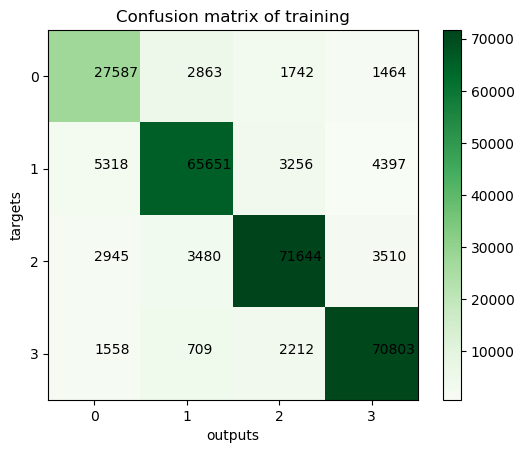

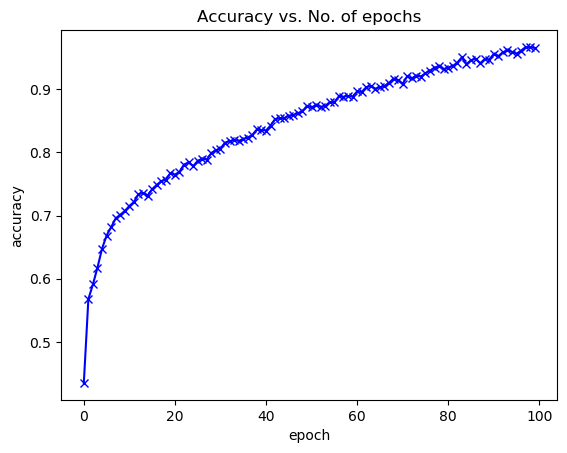

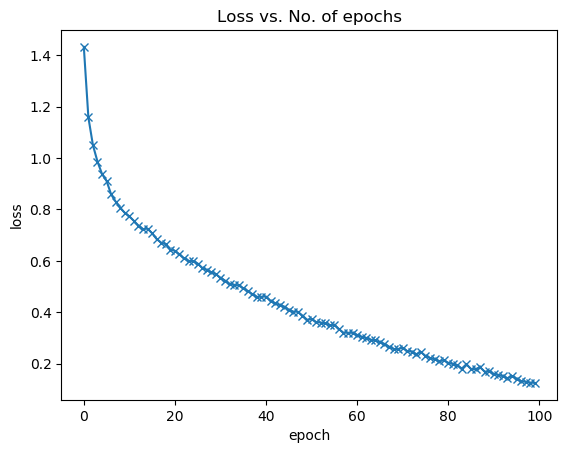

In [30]:
model6 = ConvNet().to(device)
train(model6)

In [53]:
torch.save(model6.state_dict(), 'model6_params.pth')

In [35]:
model6_ = ConvNet().to(device)
model6_.load_state_dict(torch.load('model6_params.pth'))

<All keys matched successfully>

In [33]:
inference_time = 0
for i in range(32):
    data, label = train_loader.dataset[i]
    data = data.unsqueeze(0)
    data = data.to(device)

    torch.cuda.synchronize()
    start = time.time()

    output = model6_(data)

    torch.cuda.synchronize()
    end = time.time()

    inference_time += (end - start)
print("Время инференса модели при обработке одного изображения：", inference_time/32, "с")

Время инференса модели при обработке одного изображения： 0.01487278938293457 с


In [37]:
data, label = train_loader.dataset[2]
data = data.unsqueeze(0)
data = data.to(device)

torch.cuda.synchronize()
start = time.time()

output = model6_(data)

torch.cuda.synchronize()
end = time.time()

inference_time = (end - start)
print("Время инференса модели при обработке одного изображения：", inference_time, "с")

Время инференса модели при обработке одного изображения： 0.00904703140258789 с


In [52]:
outputs_val = []
targets_val = []
with torch.no_grad():
    for data, label in valid_loader:
        data = data.to(device)
        label = label.to(device)
        val_output = model6_(data)
        outputs_val.extend(item.cpu().detach().numpy() for item in val_output.argmax(1))
        targets_val.extend(item.cpu().detach().numpy() for item in label)

sklearn_report2 = classification_report(targets_val, outputs_val)
print("Classification report of validation:")
print(sklearn_report2)

Classification report of validation:
              precision    recall  f1-score   support

           0       0.71      0.72      0.72        98
           1       0.86      0.69      0.77       192
           2       0.84      0.86      0.85       202
           3       0.91      0.94      0.92       204
           4       0.74      0.86      0.79       152

    accuracy                           0.82       848
   macro avg       0.81      0.81      0.81       848
weighted avg       0.83      0.82      0.82       848



# Test

In [42]:
test_dir = './validation'
test_list = []
test_labels_list = []
for i in labels:
    test_path = os.path.join(test_dir,i)
    temp1 = glob.glob(os.path.join(test_path,'*.jpg'))
    test_list += temp1
    temp2 = [i for j in range(len(temp1))]
    test_labels_list += temp2

In [43]:
print(f"Data: {len(test_list)}")
print(f"Labels: {len(test_labels_list)}")

Data: 54
Labels: 54


In [44]:
test_data = FlowerDataset(test_list, transform=val_transforms)
print(len(test_data))
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
print(len(test_loader))

54
2


In [45]:
test_data[0][0].shape

torch.Size([3, 224, 224])

## Model1

In [ ]:
model2 = Vgg16_net().to(device)
model2.load_state_dict(torch.load('model3_params.pth'))

In [46]:
inference_time = 0
for i in range(32):
    data, label = test_loader.dataset[i]
    data = data.unsqueeze(0)
    data = data.to(device)

    torch.cuda.synchronize()
    start = time.time()

    output = model2(data)

    torch.cuda.synchronize()
    end = time.time()

    inference_time += (end - start)
print("Время инференса модели при обработке одного изображения：", inference_time/32, "с")

Время инференса модели при обработке одного изображения： 0.017104901373386383 с


In [47]:
outputs_test = []
targets_test = []
with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)
        test_output = model2(data)
        outputs_test.extend(item.cpu().detach().numpy() for item in test_output.argmax(1))
        targets_test.extend(item.cpu().detach().numpy() for item in label)

sklearn_report2 = classification_report(targets_test, outputs_test)
print("Classification report of test:")
print(sklearn_report2)

Classification report of test:
              precision    recall  f1-score   support

           0       1.00      0.44      0.62         9
           1       0.77      1.00      0.87        10
           2       0.73      0.80      0.76        10
           3       0.80      0.92      0.86        13
           4       1.00      0.92      0.96        12

    accuracy                           0.83        54
   macro avg       0.86      0.82      0.81        54
weighted avg       0.86      0.83      0.82        54



# Model 2

In [54]:
model6_ = ConvNet().to(device)
model6_.load_state_dict(torch.load('model6_params.pth'))

<All keys matched successfully>

In [55]:
inference_time = 0
for i in range(32):
    data, label = test_loader.dataset[i]
    data = data.unsqueeze(0)
    data = data.to(device)

    torch.cuda.synchronize()
    start = time.time()

    output = model6_(data)

    torch.cuda.synchronize()
    end = time.time()

    inference_time += (end - start)
print("Время инференса модели при обработке одного изображения：", inference_time/32, "с")

Время инференса модели при обработке одного изображения： 0.009395822882652283 с


In [56]:
outputs_test = []
targets_test = []
with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)
        test_output = model6_(data)
        outputs_test.extend(item.cpu().detach().numpy() for item in test_output.argmax(1))
        targets_test.extend(item.cpu().detach().numpy() for item in label)

sklearn_report2 = classification_report(targets_test, outputs_test)
print("Classification report of test:")
print(sklearn_report2)

Classification report of test:
              precision    recall  f1-score   support

           0       0.50      0.11      0.18         9
           1       0.75      0.90      0.82        10
           2       0.60      0.60      0.60        10
           3       0.69      0.69      0.69        13
           4       0.65      0.92      0.76        12

    accuracy                           0.67        54
   macro avg       0.64      0.64      0.61        54
weighted avg       0.64      0.67      0.63        54

